# Change NaMut before running

running model at /ghazaleh/Neuron_Model_HMM run dir is /ghazaleh
ran working
using wt_file na12WT3
updating ['na12'] with {'a1_0': 2.429666594996582, 'a1_1': 0.044244542778632004, 'b1_0': 0.7286692995039887, 'b1_1': 0.06952982757643832, 'a2_0': 6204.820201739884, 'a2_1': 0.13070224427007862, 'b2_0': 797.6077523565608, 'b2_1': 0.19562008675321318, 'a3_0': 218.91724035330077, 'a3_1': 0.16191659929284918, 'b3_0': 3080.738457191511, 'b3_1': 0.016493962745893074, 'bh_0': 0.21138260460030908, 'bh_1': 2.800849199329988, 'bh_2': 0.11261781629256429, 'ah_0': 2.3050883622931004, 'ah_1': 77545.8869487112, 'ah_2': 0.0006685395263358665, 'vShift': -26.13746818612549, 'vShift_inact': 21.437824522365858, 'maxrate': 4754.97773178582, 'ahfactor': 210.0114379719879, 'bhfactor': 12.581449212564298}
using mut_file na12WT3
updating ['na12mut'] with {'a1_0': 2.429666594996582, 'a1_1': 0.044244542778632004, 'b1_0': 0.7286692995039887, 'b1_1': 0.06952982757643832, 'a2_0': 6204.820201739884, 'a2_1': 0.13070224

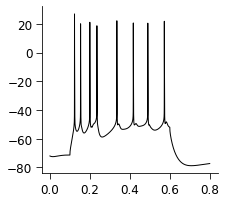

<AxesSubplot:>

<Figure size 432x288 with 0 Axes>

In [5]:
from NaMut import *
import matplotlib.pyplot as plt
import numpy as np
import NrnHelper as NH
sim = NaMut(mut_name = 'na12WT3', wt_file= 'na12WT3')
sim.make_wt()
#sim = NaMut(mut_name = 'R850P_3March_GY')
#sim.make_het()
#sim= NaMut(mut_name = 'R850P', wt_file= 'R850P')
#sim.make_wt()
#'9Dec_prst10_SSIslope100_b10_3'= 'R850P'

fig_volts,axs_volts = plt.subplots(1,figsize=(cm_to_in(8),cm_to_in(7.8)))
sim.plot_stim(axs = axs_volts,dt=0.1,stim_amp = 0.5,rec_extra = True)



In [ ]:
sim.plot_currents(stim_amp = 0.7)

In [6]:
def detect_spikes(Vm, time, dVdt_thresh = 15, min_spike_len = 0.0002, properties=True):
    '''
    Method for idenifying spikes based on rates of change in the membrane potential
    INPUTS:
    Vm: array-like - membrane potential (mV)
    time: array-like - time corresponding to Vm (sec)
    dVdt_thresh: float - Threshold for determining spike initiation (V/s)
    min_spike_len: float - Minimum length of time dVdt must be above dVdt_thresh to be considered a spike (sec)
    properties: Bool - If true, returns spike_times and spike_properties. Otherwise returns only spike_properties

    Output:
    array of spike times

    Identification of spike start times:
    dVdt is first quanitified from Vm and time
    Continuous tretches (runs) of dVdt above dVdt_thresh are identified, and then esured to last longer than min_spike_len

    Spike Property measurement:
    spike_end is determined by finding the second zero crossing of dVdt after spike dVdt_threshold
    First zero crossing is AP peak, second should be end of repolarization phase
    Persistent zero crossing (must stay above zero for 3 continous points) is used to make sure that noise in slowly repolarizing spikes doesn't trigger spike end
    '''
    if len(Vm) != len(time):
        raise Exception("Vm and time must be the same length")

    #determine stretches where dVdt exceeds dVdt_thresh
    dVdt = np.gradient(Vm,time)/1e3
    runs = group_consecutives(np.argwhere((dVdt>=dVdt_thresh)).flatten())

    #If runs are longer than min_spike_len count as a spike
    dt = time[1]-time[0] #sample rate
    min_run_len = np.ceil(min_spike_len/dt)
    spike_times = []
    for run in runs:
        if len(run) > min_run_len:
            spike_times.append(time[run[0]])
    spike_times = np.asarray(spike_times)

    if not properties: #just return spike_times
        return spike_times

    #get spike properties
    spike_properties=[]
    for spike_time in spike_times:
        #find index of spike_time in time
        spike_start_idx = np.argwhere(spike_time == time)[0][0]

        #find zero crossings of dVdt after spike dVdt_threshold
        zero_crosses = find_zero_crossing(dVdt[spike_start_idx:-1])
        #make sure zero cross is persistent to account for noise
        if len(zero_crosses) > 1:
            spike_end_idx = spike_start_idx\
                            + zero_crosses[np.argwhere(np.diff(zero_crosses)>3)[0] + 1][0]
        else: #Vm ends before spike can repolarize, therefore assigned Vm[-1] as spike end
            spike_end_idx = len(Vm)-1

        spike_Vm = Vm[spike_start_idx:spike_end_idx]
        spike_time = time[spike_start_idx:spike_end_idx] - time[spike_start_idx]
        spike_dVdt = dVdt[spike_start_idx:spike_end_idx]
        spike = {}
        spike['start_idx'] = spike_start_idx
        spike['start_time'] = time[spike_start_idx]
        spike['end_idx'] = spike_end_idx
        spike['end_time'] = time[spike_end_idx]
        spike['Vm'] = spike_Vm
        spike['time'] = spike_time
        spike['thresh'] = spike_Vm[0]
        spike['peak_Vm'] = spike_Vm.max()
        spike['height'] = np.max(spike_Vm)-spike_Vm[0]
        spike['AHP'] = spike_Vm[0]-spike_Vm[-1]
        spike['peak_dVdt'] = spike_dVdt.max()
        spike['min_dVdt'] = spike_dVdt.min()
        try:
            half_pnts = find_zero_crossing(spike_Vm - (spike_Vm[0]+(np.max(spike_Vm)-spike_Vm[0])/2))
            spike['half_width'] = (half_pnts[1]-half_pnts[0])*dt*1000
        except: #For slowly repolarizing spikes this can sometimes fail
            spike['half_width'] = np.nan

        spike_properties.append(spike)
    return spike_times,spike_properties

def detect_spike_times(Vm, time, dVdt_thresh = 15, min_spike_len = 0.0002):
    '''
    Wrapper of detect_spikes to only get spike times
    '''
    return detect_spikes(Vm, time,
                          dVdt_thresh = dVdt_thresh,
                          min_spike_len = min_spike_len,
                          properties=False)

def detect_spike_properties(Vm, time, dVdt_thresh = 15, min_spike_len = 0.0001):
    '''
    Wrapper of detect_spikes to only get spike properties
    '''
    return detect_spikes(Vm, time,
                          dVdt_thresh = dVdt_thresh,
                          min_spike_len = min_spike_len,
                          properties=True)[1]

def group_consecutives(vals, step=1):
    """Return list of consecutive lists of numbers from vals (number list)."""
    run = []
    result = [run]
    expect = None
    for v in vals:
        if (v == expect) or (expect is None):
            run.append(v)
        else:
            run = [v]
            result.append(run)
        expect = v + step
    return result

def find_zero_crossing(x):
    '''
    returns array of indicies before a zero crossing occur
    If your input array starts and stops with zeros, it will find a zero crossing at the beginning, but not at the end
    '''
    zero_crossings = np.where(np.diff(np.signbit(x)))[0]
    return zero_crossings



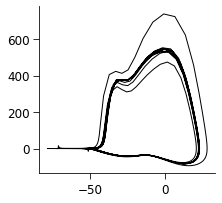

In [7]:
Vm, I, time = sim.give_VIt(0.5)
dVdt = np.gradient(Vm,time)/1e3
fig,axs = plt.subplots(1,figsize=(cm_to_in(8),cm_to_in(7.8)))
axs.plot(Vm,dVdt, label='Vm', color='black',linewidth=1)


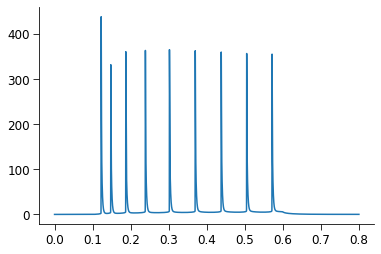

[438.60133215 332.13291519 361.03333694 363.82904897 365.51397945
 363.17648916 360.26501018 357.00426331 355.62968149] 8.159265367489557


In [8]:
I_K = I['K']*1000
I_Na = I['Na']*1000  
plt.plot(time,I_K)
plt.show()
from numpy import trapz
area= trapz(I_K, dx=time[1]-time[0])
from scipy.signal import find_peaks
peaks, _ = find_peaks(I_K, height=300)
print(I_K[peaks],area)

In [9]:
Vm, I, time = sim.give_VIt(0.07)
spike_times,spike_properties = detect_spikes(Vm,time)
print(len(spike_times))

0


In [12]:
minimum = 0.07843750000000002
maximum = 0.07859375000000002 #to define the range of current stimulation. min and max are in nA
x = 1
while x<12:
    Vm, I, time = sim.give_VIt((maximum+minimum)/2)
    spike_times,spike_properties = detect_spikes(Vm,time)
    if len(spike_times) >= 1 :
        maximum= (maximum+minimum)/2
        print ("the new Range is", [minimum, maximum])
        x+=1
        
    else:
        minimum =  (maximum+minimum)/2
        print ("the new Range is", [minimum, maximum])
        x+=1
        #rheo_range=np.linspace(minimum, maximum, 10)

        
print(maximum)
#78.56 for na12wt3

the new Range is [0.07851562500000002, 0.07859375000000002]
the new Range is [0.07855468750000003, 0.07859375000000002]
the new Range is [0.07855468750000003, 0.07857421875000002]
the new Range is [0.07855468750000003, 0.07856445312500002]
the new Range is [0.07855468750000003, 0.07855957031250002]


KeyboardInterrupt: 

1
2
3
4
5
[72, 74, 76, 78, 80] [0, 0, 0, 0, 1]
6
7
8
9
10
[72, 74, 76, 78, 80, 82, 84, 86, 88, 90] [0, 0, 0, 0, 1, 1, 1, 1, 1, 1]
11
12
13
14
15
[72, 74, 76, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100] [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2]
16
17
18
19
20
[72, 74, 76, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110] [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2]
21
22
23
24
25
[72, 74, 76, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120] [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
26
27
28
29
30
[72, 74, 76, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130] [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
31
32
33
34
35
[72, 74, 76, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 1

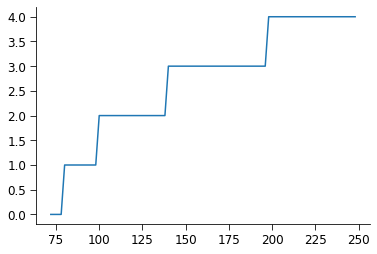

In [14]:
m=[]
n=[]
for i in range (1,90):
    Vm, I, time = sim.give_VIt(0.07+i/500)
    spike_times,spike_properties = detect_spikes(Vm,time)
    m.append(70+i*2)
    n.append(len(spike_times))
    print(i)
    if i%5==0:
        print(m,n)
    

plt.plot(m,n)
plt.show()    

In [ ]:
Vm, I, time = sim.give_VIt(0.6)
spike_times,spike_properties = detect_spikes(Vm,time)
print(len(spike_times))
# for wt at 0.6 is 12
# for het at 0.6 is 11
#homo 11 and at 0.7 is 13

In [ ]:
print(x,y)
print(m,n)
print(p,q)
"""
[0.0395, 0.079, 0.1185, 0.158, 0.1975, 0.237, 0.2765, 0.316, 0.3555, 0.395, 0.4345, 0.474, 0.5135, 0.553, 0.5925, 0.632, 0.6715, 0.711, 0.7505000000000001, 0.79, 0.8295, 0.869, 0.9085, 0.948, 0.9875, 1.027, 1.0665, 1.106, 1.1455] [0, 0, 2, 3, 4, 4, 5, 5, 6, 7, 7, 8, 9, 10, 11, 11, 12, 13, 14, 15, 15, 16, 17, 18, 18, 19, 20, 20, 21]
[0.0395, 0.079, 0.1185, 0.158, 0.1975, 0.237, 0.2765, 0.316, 0.3555, 0.395, 0.4345, 0.474, 0.5135, 0.553, 0.5925, 0.632, 0.6715, 0.711, 0.7505000000000001, 0.79, 0.8295, 0.869, 0.9085, 0.948, 0.9875, 1.027, 1.0665, 1.106, 1.1455] [0, 0, 2, 3, 4, 4, 5, 5, 6, 7, 7, 8, 9, 10, 11, 11, 12, 13, 14, 15, 15, 16, 17, 18, 18, 19, 20, 20, 21]
[0.0395, 0.079, 0.1185, 0.158, 0.1975, 0.237, 0.2765, 0.316, 0.3555, 0.395, 0.4345, 0.474, 0.5135, 0.553, 0.5925, 0.632, 0.6715, 0.711, 0.7505000000000001, 0.79, 0.8295, 0.869, 0.9085, 0.948, 0.9875, 1.027, 1.0665, 1.106, 1.1455] [0, 0, 2, 3, 4, 4, 5, 5, 6, 7, 7, 8, 9, 10, 11, 11, 12, 13, 14, 15, 15, 16, 17, 18, 18, 19, 20, 20, 21]

"""

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
plt.plot(x,y)
plt.plot(m,n)
plt.plot(p,q)
plt.show()

In [ ]:
# hetero
"""
x=[]
y=[]
for i in range (5,15):
    Vm, I, time = sim.give_VIt(i*0.078/5)
    spike_times,spike_properties = detect_spikes(Vm,time)
    numb_spike = len(spike_times)
    x.append(i*0.078/5)
    y.append(numb_spike)
    print(x,y)  
"""
"""
#homo rheo is 79. something

for i in range (70,91,7):
    Vm, I, time = sim.give_VIt(i/100)
    spike_times,spike_properties = detect_spikes(Vm,time)
    numb_spike = len(spike_times)
    m.append(i/100)
    n.append(numb_spike)
    print(m,n)
#[0.07, 0.14, 0.21, 0.28, 0.35, 0.42, 0.49, 0.56, 0.63, 0.7, 0.77, 0.84] [0, 3, 4, 5, 6, 7, 8, 10, 11, 13, 14, 16]
"""

#WT rheo is 78.55
p=[]
q=[]
for i in range (7,91,7):
    Vm, I, time = sim.give_VIt(i/100)
    spike_times,spike_properties = detect_spikes(Vm,time)
    numb_spike = len(spike_times)
    p.append(i/100)
    q.append(numb_spike)
    print(p,q)
#[0.078, 0.09359999999999999, 0.1092, 0.1248, 0.1404, 0.156, 0.1716, 0.18719999999999998, 0.2028, 0.2184] [0, 1, 2, 2, 3, 3, 3, 3, 4, 4]
#[0.07, 0.14, 0.21, 0.28, 0.35, 0.42, 0.49, 0.56, 0.63, 0.7, 0.77, 0.84] [0, 3, 4, 5, 6, 7, 9, 11, 12, 13, 15, 16]
